In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


## Language dataset

In [22]:
class LanguageDataset(Dataset):
    '''
    Args:
    
    Returns:
    '''
    def __init__(self, min_length, max_length, p, num_samples):
        self.min_length = min_length
        self.max_length = max_length
        self.p = p
        self.num_samples = num_samples
        self.samples = self.generate_samples()
        self.avg_len = self.average_length(self.samples)
    
    def generate_samples(self):
        samples = []
        for _ in range(self.num_samples):
            length = np.random.randint(self.min_length, self.max_length + 1)
            if np.random.rand() < self.p:
                n = length // 3
                sequence = 'a' * n + 'b' * n + 'c' * n
            else:
                # Generate an invalid sequence
                sequence = self.generate_invalid_sequence(length)
            samples.append((sequence, int(self.is_language(sequence))))
        return samples
    
    def generate_invalid_sequence(self, length):
        sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        while self.is_language(sequence):
            sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        return sequence
    
    def is_language(self, sequence):
        length = len(sequence)
        if length % 3 != 0:
            return False
        
        # calculate n
        n = length // 3

        if sequence[:n] == 'a' * n and sequence[n:2*n] == 'b' * n and sequence[2*n:] == 'c' * n:
            return True
        
        return False
    
    def average_length(self, samples):
        return np.mean([len(sequence) for sequence, _ in self.samples])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        indices = torch.tensor([ord(c) - ord('a') for c in sequence], dtype=torch.long)
        one_hot_sequence = torch.nn.functional.one_hot(indices, num_classes=3).float()
        return one_hot_sequence, torch.tensor(label)

def collate_fn(batch):
    '''
    Args:
    
    Returns:
    '''
    sequences, labels = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels


def generate_data(min_length, max_length, p, num_samples, batch_size=32):
    '''
    Args:
    
    Returns:
    '''
    dataset = LanguageDataset(min_length, max_length, p, num_samples)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return data_loader

## Model definition

In [23]:
class RNNCell(nn.Module):
    '''
    Args:
    
    Returns:
    '''
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.h2o(hidden)
        return output, hidden

class RNN(nn.Module):
    '''
    Args:
    
    Returns:
    '''
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.RNN_layers = nn.ModuleList([RNNCell(input_size, hidden_size) for _ in range(n_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(0))
        outputs = []
        for layer_idx in range(self.n_layers):
            layer_outputs = []
            for input_idx in range(input.size(1)):
                x = input[:, input_idx, :]
                output, hidden[layer_idx] = self.RNN_layers[layer_idx](x, hidden[layer_idx])
                layer_outputs.append(output)
            outputs.append(torch.stack(layer_outputs, dim=1))
            input = outputs[-1]
        output = self.fc(outputs[-1][:, -1, :])
        return output

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]


## Training and evaluation functions

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    '''
    Args:
    
    Returns:
    '''
    best_val_acc = 0
    best_model = None
    for epoch in range(num_epochs):
        model.train()
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            hidden = model.init_hidden(sequences.size(0))
            outputs = model(sequences, hidden)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                hidden = model.init_hidden(sequences.size(0))
                outputs = model(sequences, hidden)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
    return best_model, best_val_acc


In [25]:
def eval_model(model, data_loader, criterion='accuracy'):
    '''
    Args:
    
    Returns:
    '''
    model.eval()  # Set model to eval mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for batch in data_loader:  # Iterate over batches
            sequences, labels = batch  # Unpack the batch
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    if criterion == 'accuracy':
        return accuracy_score(true_labels, pred_labels)
    elif criterion == 'f1':
        return f1_score(true_labels, pred_labels)
    else:
        raise ValueError("Invalid criterion. Choose 'accuracy' or 'f1'.")



### Generate data

In [26]:
# After generating the data loader, split it into train, validation, and test sets
data_loader = generate_data(1, 20, 0.5, 1000, 32)

train_size = int(0.7 * len(data_loader.dataset))
train_data, val_data = random_split(data_loader.dataset, [train_size, len(data_loader.dataset) - train_size])
print(len(train_data), len(val_data))

test_data = generate_data(21, 100, 0.5, 1000, 32).dataset

# Create separate data loaders for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Hyperparameter tuning

In [27]:
input_size = 3  # 'a', 'b', 'c'
output_size = 2  # 0 or 1
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

best_val_acc = 0
best_model = None

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = RNN(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model

print(f'Best validation accuracy: {np.round(best_val_acc,3)}')

Best validation accuracy: 0.977


## Evaluation

In [28]:
# Evaluate the model on the validation set
val_accuracy = eval_model(best_model, val_loader, criterion='accuracy')
val_f1_score = eval_model(best_model, val_loader, criterion='f1')


print(f'Validation Accuracy: {np.round(val_accuracy,3)}')
print(f'Validation F1 Score: {np.round(val_f1_score,3)}')

# Evaluate the model on the test set
test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
test_f1_score = eval_model(best_model, test_loader, criterion='f1')

print(f'Test Accuracy: {np.round(test_accuracy,3)}')
print(f'Test F1 Score: {np.round(test_f1_score,3)}')


Validation Accuracy: 0.977
Validation F1 Score: 0.975
Test Accuracy: 0.962
Test F1 Score: 0.964


## Plot results

In [29]:
# Initialize lists to store performance metrics
accuracy_per_length = []
f1_score_per_length = []

# Evaluate the model on sequences of lengths ranging from 21 to 100
for length in range(21, 101):
    test_data = generate_data(length, length, 0.5, 1000, 32).dataset
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Evaluate the model on the test set
    test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
    test_f1_score = eval_model(best_model, test_loader, criterion='f1')
    
    accuracy_per_length.append(test_accuracy)
    f1_score_per_length.append(test_f1_score)



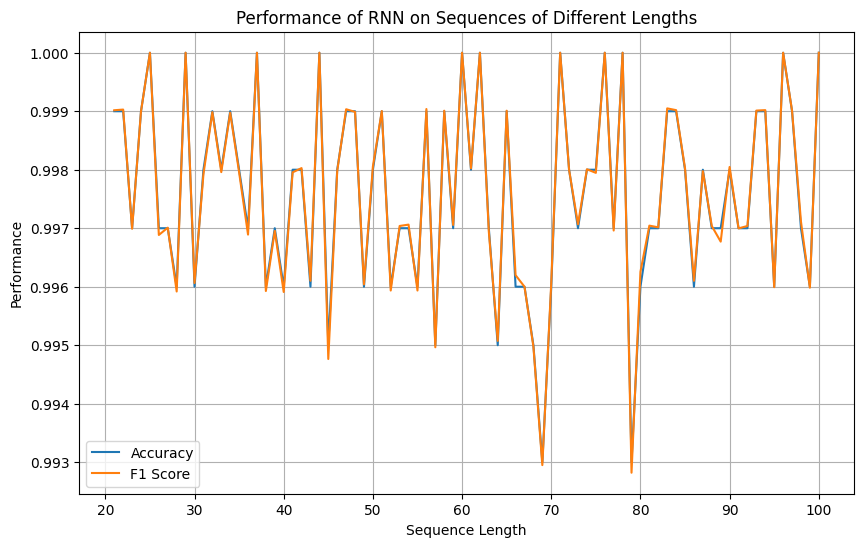

In [30]:
# Plot performance over sentence length
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='Accuracy')
plt.plot(range(21, 101), f1_score_per_length, label='F1 Score')
plt.xlabel('Sequence Length')
plt.ylabel('Performance')
plt.title('Performance of RNN on Sequences of Different Lengths')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
accuracy_per_length_np = np.array(accuracy_per_length)
np.savetxt('RNN_acc.csv', accuracy_per_length_np, delimiter=',')